In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000)

from calitp_data_analysis.tables import tbls

from siuba import *
import pandas as pd
import geopandas as gpd

import datetime as dt
from rt_analysis import signal_tools

In [3]:
path = './signals_2023-06-12.xlsx'
signal_gdf = signal_tools.read_signal_excel(path)

# Test Scripts

In [5]:
progress_df = pd.read_parquet('./_rt_progress_2023-07-12.parquet') >> filter(_.status == 'map_confirmed')

In [6]:
analysis_date = progress_df.analysis_date.iloc[0]

In [7]:
# all_segment_gdf = signal_tools.all_day_speedmap_segments(progress_df=progress_df)

In [8]:
# segment_lines_all = signal_tools.copy_segment_speeds(progress_df)

In [9]:
# all_segment_gdf.to_parquet(f'segments_all_{analysis_date}.parquet')

In [10]:
# segment_lines_all.to_parquet(f'./segment_lines_all_{analysis_date}.parquet')

In [11]:
segments_all = gpd.read_parquet(f'segments_all_{analysis_date}.parquet')

In [10]:
segment_lines_all = gpd.read_parquet(f'./segment_lines_all_{analysis_date}.parquet')

In [20]:
joined_seg_lines = signal_tools.sjoin_signals(signal_gdf = signal_gdf, segments_gdf = segments_all,
                                              segments_lines_gdf = segment_lines_all)

In [23]:
joined_seg_lines = signal_tools.determine_approaching(joined_seg_lines)

In [24]:
median_by_signal = signal_tools.calculate_scores(joined_seg_lines)

In [25]:
median_by_signal >> arrange(-_.overall_transit_score)

,imms_id,location,speed_score,variability_score,frequency_score,overall_transit_score
948,04SM082 -E35I6,BALDWIN AVE/BAYWOOD AVE and EL CAMINO REAL (RT...,7.0,8.0,10.0,25.0
200,04ALA013 - EZ132,COLLEGE AVE and ASHBY AVE (RTE 13),6.0,8.5,10.0,24.5
563,04NAP029 -E21C5,WASHINGTON ST and LINCOLN AVE (RTE 29),7.5,7.0,10.0,24.5
201,04ALA013 - EZ133,COLBY ST and ASHBY AVE (RTE 13),4.0,10.0,10.0,24.0
562,04NAP029 -E21B9,ADAMS ST and MAIN ST (RTE 29/128),6.5,7.5,10.0,24.0
...,...,...,...,...,...,...
1502,07LA001 -ED160,BLUFF CREEK,1.0,3.0,0.0,4.0
2024,07LA405 -ED537,SB HOWARD HUGHES PKWY,1.0,3.0,0.0,4.0
2516,11SD094 -E8005,DAISY DR,0.0,4.0,0.0,4.0
1717,07LA101 -E0400,101 FWY SB MISSION -ALISO,0.0,3.0,0.0,3.0


## Reference Histograms for subscores

<AxesSubplot:>

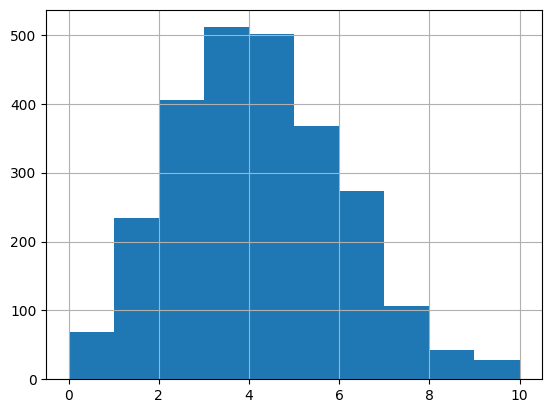

In [26]:
median_by_signal.speed_score.hist()

<AxesSubplot:>

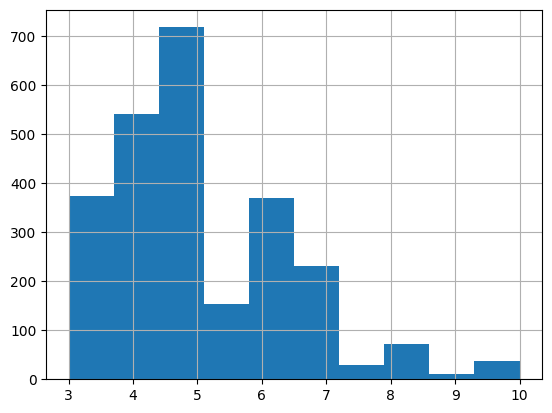

In [27]:
median_by_signal.variability_score.hist()

<AxesSubplot:>

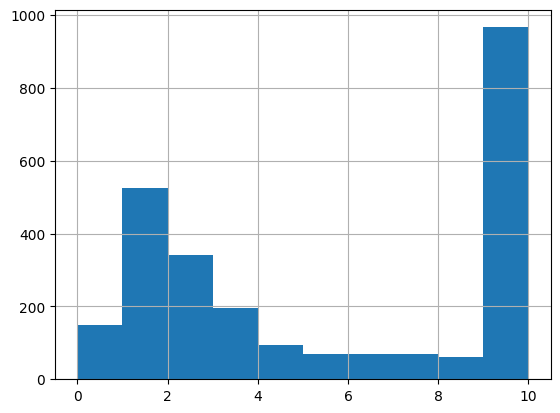

In [28]:
median_by_signal.frequency_score.hist()

<AxesSubplot:>

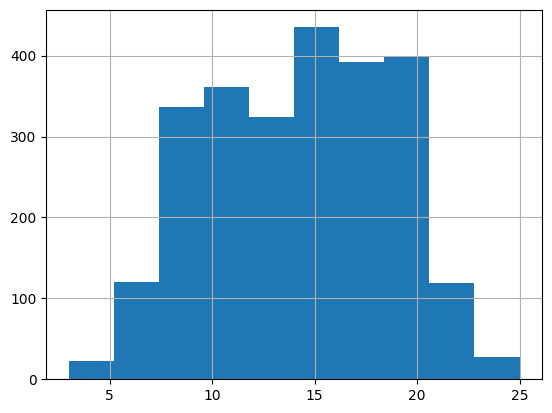

In [29]:
median_by_signal.overall_transit_score.hist()

## Provide All SHS Segments

In [16]:
from shared_utils.rt_utils import SHN_PATH
from shared_utils.geography_utils import CA_NAD83Albers
import dask_geopandas as dg

In [11]:
segment_lines_all >> head(3)

,stop_id,stop_name,geometry,shape_id,shape_meters,trip_id,stop_sequence,route_id,route_short_name,direction_id,...,meters_from_last,speed_from_last,delay_chg_sec,speed_mph,n_trips_shp,p50_mph,p20_mph,p80_mph,fast_slow_ratio,trips_per_hour
0,evanhall,Evans Hall: Hearst Mining Circle,"LINESTRING (-198171.124 -13291.509, -198135.81...",ntsafens_loop_1,2301.375928,21,9.0,ntsafens,Night Safety North,0.0,...,853.489613,2.570752,152.0,5.750772,11,6.917595,5.750772,8.639169,1.502262,87.272727
1,evanhall,Evans Hall: Hearst Mining Circle,"LINESTRING (-198171.124 -13291.509, -198135.81...",ntsafens_loop_1,2301.375928,26,9.0,ntsafens,Night Safety North,0.0,...,853.489613,2.634227,144.0,5.892766,11,6.917595,5.750772,8.639169,1.502262,87.272727
2,evanhall,Evans Hall: Hearst Mining Circle,"LINESTRING (-198171.124 -13291.509, -198135.81...",ntsafens_loop_1,2301.375928,22,9.0,ntsafens,Night Safety North,0.0,...,853.489613,4.849373,-3.0,10.848047,11,6.917595,5.750772,8.639169,1.502262,87.272727


In [12]:
# add line geometries from stop_segment_speed_view
seg_lines = (segment_lines_all
            >> select(_.line_geom == _.geometry, _.shape_id, _.stop_sequence, _.stop_id)
            >> distinct(_.line_geom, _.shape_id, _.stop_sequence, _.stop_id)
        )
# ideally a more robust join in the future
joined_seg_lines = segments_all >> inner_join(_, seg_lines, on = ['shape_id', 'stop_sequence', 'stop_id'])

In [13]:
joined_seg_lines = joined_seg_lines.set_geometry('line_geom', drop = True)

In [31]:
joined_seg_lines >> head(3)

,stop_id,stop_name,geometry,shape_id,stop_sequence,route_id,route_short_name,direction_id,p50_mph,p20_mph,p80_mph,fast_slow_ratio,trips_per_hour,miles_from_last,time_formatted,feed_key,gtfs_dataset_key,system_p50_median
0,7730800,W MacArthur & Broadway (Ac Sonoma Vly HS),"LINESTRING (-214719.926 33181.166, -214799.960...",p_2780,3.0,30X,30X,1.0,30.4,30.4,30.4,1.0,0.1,0.4,0:47,402c0571c894b9244eb105489451f5e4,09e16227fc42c4fe90204a9d11581034,23.2
1,7730800,W MacArthur & Broadway (Ac Sonoma Vly HS),"LINESTRING (-214719.926 33181.166, -214799.960...",p_2780,3.0,30X,30X,1.0,30.4,30.4,30.4,1.0,0.1,0.4,0:47,402c0571c894b9244eb105489451f5e4,09e16227fc42c4fe90204a9d11581034,23.2
2,7730900,West MacArthur St & 4th St West,"LINESTRING (-214887.669 32634.974, -215518.384...",p_2780,4.0,30X,30X,1.0,30.4,30.4,30.4,1.0,0.1,0.4,0:47,402c0571c894b9244eb105489451f5e4,09e16227fc42c4fe90204a9d11581034,23.2


In [14]:
segments_all >> head(3)

,stop_id,stop_name,geometry,shape_id,stop_sequence,route_id,route_short_name,direction_id,p50_mph,p20_mph,p80_mph,fast_slow_ratio,trips_per_hour,miles_from_last,time_formatted,feed_key,gtfs_dataset_key,system_p50_median
476,7730800,W MacArthur & Broadway (Ac Sonoma Vly HS),"POLYGON ((-214810.835 32652.824, -214824.505 3...",p_2780,3.0,30X,30X,1.0,30.4,30.4,30.4,1.0,0.1,0.4,0:47,402c0571c894b9244eb105489451f5e4,09e16227fc42c4fe90204a9d11581034,23.2
477,7730900,West MacArthur St & 4th St West,"POLYGON ((-214881.979 32679.627, -214900.928 3...",p_2780,4.0,30X,30X,1.0,30.4,30.4,30.4,1.0,0.1,0.4,0:47,402c0571c894b9244eb105489451f5e4,09e16227fc42c4fe90204a9d11581034,23.2
478,7731000,Pueblo Serena MHP,"POLYGON ((-215670.095 32775.462, -215669.204 3...",p_2780,5.0,30X,30X,1.0,30.7,30.7,30.7,1.0,0.1,0.1,0:11,402c0571c894b9244eb105489451f5e4,09e16227fc42c4fe90204a9d11581034,23.2


In [17]:
shs = gpd.read_parquet(SHN_PATH).to_crs(CA_NAD83Albers)

In [18]:
shs >> head(3)

,Route,County,District,RouteType,NB,SB,EB,WB,geometry,highway_length
0,1,LA,7,State,1,1,0,0,"MULTIPOLYGON (((144885.273 -447613.479, 144886...",325266.344392
1,1,MEN,1,State,1,1,0,0,"POLYGON ((-328501.511 157787.309, -328497.074 ...",544903.330331
2,1,MON,5,State,1,1,0,0,"POLYGON ((-173401.509 -166434.139, -173403.742...",531935.433460


In [21]:
shs_dask = dg.from_geopandas(shs, npartitions=10)

In [34]:
segs_dask = dg.from_geopandas(segments_all, npartitions=10)

In [35]:
lines_dask = dg.from_geopandas(joined_seg_lines, npartitions=10)

In [36]:
shs_segs_joined = segs_dask.sjoin(shs_dask)

In [37]:
shs_segs_joined_computed = shs_segs_joined.compute()

In [38]:
shs_segs_joined_computed >> head(3)

,stop_id,stop_name,geometry,shape_id,stop_sequence,route_id,route_short_name,direction_id,p50_mph,p20_mph,...,index_right,Route,County,District,RouteType,NB,SB,EB,WB,highway_length
0,814259,Bailey Rd & Maylard St,"POLYGON ((-170586.435 1941.541, -170665.646 19...",39,2.0,201X,201X,1.0,7.6,4.0,...,18,4,CC,4,State,0,0,1,1,243992.823131
1,812431,Bailey Rd & Canal Rd,"POLYGON ((-170208.220 1842.324, -170222.646 18...",39,3.0,201X,201X,1.0,16.3,11.1,...,18,4,CC,4,State,0,0,1,1,243992.823131
2,None,None,"POLYGON ((-200867.261 1213.771, -200707.753 13...",p_5192,22.5,J,J,0.0,20.6,20.6,...,18,4,CC,4,State,0,0,1,1,243992.823131


In [39]:
shs_lines_joined = lines_dask.sjoin(shs_dask)

In [40]:
shs_lines_joined_computed = shs_lines_joined.compute()

In [41]:
shs_lines_joined_computed >> head(3)

,stop_id,stop_name,geometry,shape_id,stop_sequence,route_id,route_short_name,direction_id,p50_mph,p20_mph,...,index_right,Route,County,District,RouteType,NB,SB,EB,WB,highway_length
3797,None,None,"LINESTRING (-129165.506 46744.082, -129188.572...",13414,15.055556,3432,14,1.0,46.9,43.6,...,29,5,SAC,3,Interstate,1,1,0,0,183399.283501
3798,None,None,"LINESTRING (-129881.817 47984.143, -129921.109...",13414,15.111111,3432,14,1.0,65.8,65.8,...,29,5,SAC,3,Interstate,1,1,0,0,183399.283501
3799,None,None,"LINESTRING (-130026.009 48973.692, -130031.702...",13414,15.166667,3432,14,1.0,65.8,65.8,...,29,5,SAC,3,Interstate,1,1,0,0,183399.283501


In [44]:
shs_lines_joined_computed.columns

Index(['stop_id', 'stop_name', 'geometry', 'shape_id', 'stop_sequence',
       'route_id', 'route_short_name', 'direction_id', 'p50_mph', 'p20_mph',
       'p80_mph', 'fast_slow_ratio', 'trips_per_hour', 'miles_from_last',
       'time_formatted', 'feed_key', 'gtfs_dataset_key', 'system_p50_median',
       'index_right', 'Route', 'County', 'District', 'RouteType', 'NB', 'SB',
       'EB', 'WB', 'highway_length'],
      dtype='object')

In [47]:
shs_lines_joined_computed = shs_lines_joined_computed >> select(-_.time_from_last, -_.index_right, -_.highway_length,
                                                            -_.EB, -_.WB, -_.NB, -_.SB)

In [48]:
shs_segs_joined_computed = shs_segs_joined_computed >> select(-_.time_from_last, -_.index_right, -_.highway_length,
                                                            -_.EB, -_.WB, -_.NB, -_.SB)

In [49]:
shs_lines_joined_computed.to_file('transit_lines_shs_joined.geojson')

In [50]:
shs_segs_joined_computed.to_file('transit_polygons_shs_joined.geojson')